<a href="https://colab.research.google.com/github/pienrium/NDVI-Analysis-Nilufer/blob/main/nilufer_NDVI_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kentsel Yeşil Alan Değişiminin Sentinel-2 Uydu Görüntüleri Kullanılarak NDVI Analizi: Nilüfer (Bursa) Örneği (2016-2023)

  ## Harita Mühendisi Gizem Eyi

Geleneksel CBS yazılımları yüksek maliyet ve karmaşık kullanım gerektirmektedir. Python programlama dili ve Google Colab gibi bulut platformları, mekansal analizler için daha ekonomik ve kullanıcı dostu alternatifler sunmaktadır.

Bu çalışmada, Bursa Nilüfer'deki arazi örtüsü değişimi, Sentinel-2 uydu görüntüleri kullanılarak Python ve Google Colab üzerinden NDVI analizi ile incelenmiştir. 2016-2023 yılları arasındaki değişim, geleneksel CBS yazılımlarına göre daha verimli bir yaklaşımla analiz edilmiştir.

In [ ]:
!pip install pystac-client
!pip install planetary-computer
!pip install rasterio
!pip install geopandas
!pip install folium
!pip install odc-stac
!pip install rioxarray
!pip install pandas
!pip install sentinelsat
!pip install earthpy

**Kullanılan Python Kütüphaneleri**


*  	**pystac_client ve planetary_computer:** Microsoft Planetary Computer platformundan Sentinel-2 uydu görüntülerinin sistematik bir şekilde indirilmesini sağlayan API kütüphaneleridir.
*   **rasterio:** Farklı mekansal çözünürlüklere sahip uydu görüntüsü bantlarının (10m, 20m ve 60m) okunması ve işlenmesi için kullanılmaktadır.
*   **geopandas:** Coğrafi verileri (nokta, çizgi, poligon) işlemek ve analiz etmek için kullanılan, Pandas kütüphanesinin mekansal veri işleme yetenekleriyle genişletilmiş açık kaynaklı bir kütüphanedir.
*  **numpy:**  Çok boyutlu diziler ve matrisler üzerinde hızlı matematiksel işlemler yapmayı sağlayan, bilimsel hesaplamalar için temel oluşturan bir kütüphanedir.
*   **pandas:** Veri manipülasyonu ve analizi için kullanılan, verileri tablo benzeri DataFrame yapısında düzenleyen ve güçlü veri işleme araçları sunan bir kütüphanedir.
*   **matplotlib ve seaborn:** Veri görselleştirme için kullanılan kütüphanelerdir.


**Proje Dizin Yapısı Oluşturma**
-------------------------------------------------------
Bu script, uzaktan algılama analizleri için gerekli klasör yapısını oluşturur.
Çalışma dizininde aşağıdaki alt klasörler oluşturuldu:
- nilufer_boundary: Çalışma alanı sınır verileri (shapefile)
- satellite_images: Ham uydu görüntüleri
- ndvi_analysis: NDVI analiz sonuçları
- ndbi_analysis: NDBI analiz sonuçları
- ui_analysis: UI analiz sonuçları
- results: Yayında kullanılacak final görseller



In [ ]:
import os
from google.colab import drive

def create_project_structure(base_directory):
    """
    Proje için gerekli klasör yapısını oluşturur.

    Parametreler:
    -------------
    base_directory : str
        Projenin ana dizin yolu
    """

    # Alt klasör listesi ve açıklamaları
    project_folders = {
        'nilufer_boundary': 'Çalışma alanı sınır verileri',
        'satellite_images': 'Ham uydu görüntüleri',
        'ndvi_analysis': 'NDVI analiz sonuçları',
        'ndbi_analysis': 'NDBI analiz sonuçları',
        'ui_analysis': 'UI analiz sonuçları',
        'results': 'Final görseller'
    }

    # Google Drive'a bağlan
    try:
        drive.mount('/content/drive')
        print("Google Drive bağlantısı başarılı!")
    except Exception as e:
        print(f"Google Drive bağlantısı başarısız: {e}")
        return

    # Ana proje dizinini oluştur
    if not os.path.exists(base_directory):
        os.makedirs(base_directory)
        print(f"\nAna proje dizini oluşturuldu: {base_directory}")

    # Alt klasörleri oluştur
    for folder_name, description in project_folders.items():
        folder_path = os.path.join(base_directory, folder_name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Oluşturulan klasör: {folder_name} - {description}")
        else:
            print(f"Mevcut klasör: {folder_name} - {description}")

# Scripti çalıştır
BASE_PATH = '/content/drive/My Drive/nilufer_spectral_analysis'
create_project_structure(BASE_PATH)
print("\nDizin yapısı başarıyla oluşturuldu!")

**Sentinel-2 Uydu Görüntüsü Arama**
--------------------------------------
Bu script, Microsoft Planetary Computer platformunu kullanarak Bursa'nın Nilüfer ilçesi için Sentinel-2 uydu görüntülerini aramaktadır. Kod üç ana işlevi yerine getirmektedir:

1.   **get_nilufer_bounds:** Nilüfer ilçesinin sınırlarını WGS84 koordinat sisteminde tanımlar.
2.   **search_sentinel_images:** Belirlenen kriterlere göre (tarih, bulut örtüsü oranı <%10) uydu görüntülerini arar.
3.   **display_image_info:** Bulunan görüntülerin tarih, bulut oranı, ID, kapsama alanı ve UTM zonu gibi detaylarını raporlar.



In [ ]:
import pystac_client
import planetary_computer
import geopandas as gpd
from datetime import datetime

def get_nilufer_bounds(boundary_path):
    """Nilüfer ilçesi sınır koordinatlarını getirir"""
    try:
        boundary = gpd.read_file(boundary_path)
        boundary_wgs84 = boundary.to_crs('EPSG:4326')
        bounds = boundary_wgs84.total_bounds

        print("\nNilüfer ilçesi koordinatları (WGS84):")
        print(f"Batı  : {bounds[0]:.4f}")
        print(f"Güney : {bounds[1]:.4f}")
        print(f"Doğu  : {bounds[2]:.4f}")
        print(f"Kuzey : {bounds[3]:.4f}")

        return bounds.tolist()
    except Exception as e:
        print(f"Hata: Sınır dosyası yüklenemedi - {e}")
        print("Varsayılan koordinatlar kullanılıyor...")
        return [28.8, 40.1, 29.2, 40.3]

def search_sentinel_images(bbox, year, month=8, max_cloud_cover=10):
    """Belirtilen kriterlere göre görüntü arar"""
    try:
        # STAC API'ye bağlan
        catalog = pystac_client.Client.open(
            "https://planetarycomputer.microsoft.com/api/stac/v1",
            modifier=planetary_computer.sign
        )

        # Tarih aralığını belirle
        start_date = f"{year}-{month:02d}-01"
        end_date = f"{year}-{month:02d}-31"

        # Görüntü ara
        search = catalog.search(
            collections=["sentinel-2-l2a"],
            bbox=bbox,
            datetime=f"{start_date}/{end_date}",
            query={"eo:cloud_cover": {"lt": max_cloud_cover}}
        )

        return list(search.get_items())
    except Exception as e:
        print(f"Hata: Görüntü araması başarısız - {e}")
        return []

def display_image_info(items, year):
    """Bulunan görüntülerin bilgilerini gösterir"""
    print(f"\n{year} yılı için bulunan görüntüler:")

    if not items:
        print(f"!!! {year} için görüntü bulunamadı !!!")
        return

    for item in items:
        print("\n-----------------------------------")
        print(f"Tarih: {item.datetime.strftime('%Y-%m-%d')}")
        print(f"Bulut Oranı: {item.properties['eo:cloud_cover']:.2f}%")
        print(f"Görüntü ID: {item.id}")
        print(f"Kapsama Alanı: {item.properties.get('sentinel:data_coverage', 'Bilgi yok')}%")
        print(f"UTM Zonu: {item.properties.get('sentinel:utm_zone', 'Bilgi yok')}")

def main():
    # Çalışma alanı dosya yolu
    boundary_path = '/content/drive/My Drive/nilufer_spectral_analysis/nilufer_boundary/nilufer.shp'

    print("Nilüfer İlçesi Uydu Görüntüsü Arama Sistemi")
    print("-------------------------------------------")

    # Sınır koordinatlarını al
    bbox = get_nilufer_bounds(boundary_path)

    # 2016 ve 2023 için görüntü ara
    print("\nGörüntüler aranıyor...")
    items_2016 = search_sentinel_images(bbox, 2016)
    items_2023 = search_sentinel_images(bbox, 2023)

    # Sonuçları göster
    display_image_info(items_2016, "2016")
    display_image_info(items_2023, "2023")

    # Özet bilgi
    print("\nToplam bulunan görüntü sayıları:")
    print(f"2016: {len(items_2016)} görüntü")
    print(f"2023: {len(items_2023)} görüntü")

    # Eğer görüntü bulunamazsa öneriler sun
    if len(items_2016) == 0 or len(items_2023) == 0:
        print("\nÖneriler:")
        print("1. Bulut oranı limitini artırın (örn: 20%)")
        print("2. Farklı ayları deneyin (Temmuz veya Eylül)")
        print("3. Tarih aralığını genişletin")

main()

Sentinel-2 Uydu Görüntüsü İndirme Scripti
----------------------------------------
Bu script, seçilen Sentinel-2 görüntülerinin bantlarını indirir ve kaydeder.


In [ ]:
import planetary_computer
import pystac_client
import rasterio
import numpy as np
import os

# Görüntü ID'leri
IMAGE_2016 = "S2A_MSIL2A_20160816T090022_R007_T35TPE_20210212T145403"
IMAGE_2023 = "S2B_MSIL2A_20230822T084559_R107_T35TPE_20230822T141604"

# İndirilecek bantlar
BANDS = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12']

# Çıktı dizini
OUTPUT_DIR = '/content/drive/My Drive/nilufer_spectral_analysis/satellite_images'

def download_bands(catalog, item_id):
    """Görüntü bantlarını indir"""
    try:
        # Görüntüyü bul
        search = catalog.search(
            collections=["sentinel-2-l2a"],
            ids=[item_id]
        )
        item = next(search.items())

        # Bantları indir
        band_arrays = {}
        metadata = {}

        for band in BANDS:
            try:
                # Bandı indir
                signed_href = planetary_computer.sign(item.assets[band]).href

                with rasterio.open(signed_href) as ds:
                    band_arrays[band] = ds.read(1)
                    metadata[band] = {
                        'transform': ds.transform,
                        'crs': ds.crs,
                        'shape': ds.shape
                    }

                print(f"{item_id} - {band} bandı indirildi (Shape: {band_arrays[band].shape})")

            except Exception as e:
                print(f"Hata: {band} bandı indirilemedi - {e}")
                continue

        return band_arrays, metadata

    except Exception as e:
        print(f"Hata: Görüntü indirilemedi - {e}")
        return None, None

def save_data(output_dir, year, band_data, metadata):
    """Bantları ve metadata bilgilerini kaydet"""
    # Ana dizini oluştur
    os.makedirs(output_dir, exist_ok=True)

    # Metadata dizini
    metadata_dir = os.path.join(output_dir, 'metadata')
    os.makedirs(metadata_dir, exist_ok=True)

    for band, array in band_data.items():
        try:
            # Band verisini kaydet
            np.save(f"{output_dir}/{year}_{band}.npy", array)

            # Metadata bilgilerini kaydet
            if band in metadata:
                np.save(
                    f"{metadata_dir}/{year}_{band}_metadata.npy",
                    {
                        'transform': metadata[band]['transform'],
                        'crs': str(metadata[band]['crs']),
                        'shape': metadata[band]['shape']
                    }
                )

            print(f"{year} {band} bandı kaydedildi")

        except Exception as e:
            print(f"Hata: {year} {band} bandı kaydedilemedi - {e}")

def main():
    print("Sentinel-2 Görüntü İndirme İşlemi Başlıyor...")

    # STAC API'ye bağlan
    try:
        catalog = pystac_client.Client.open(
            "https://planetarycomputer.microsoft.com/api/stac/v1",
            modifier=planetary_computer.sign
        )
    except Exception as e:
        print(f"Hata: STAC API bağlantısı başarısız - {e}")
        return

    # 2016 görüntüsünü indir
    print("\n2016 görüntüsü indiriliyor...")
    bands_2016, metadata_2016 = download_bands(catalog, IMAGE_2016)

    # 2023 görüntüsünü indir
    print("\n2023 görüntüsü indiriliyor...")
    bands_2023, metadata_2023 = download_bands(catalog, IMAGE_2023)

    # Verileri kaydet
    if bands_2016 and metadata_2016:
        print("\n2016 görüntüleri kaydediliyor...")
        save_data(OUTPUT_DIR, '2016', bands_2016, metadata_2016)

    if bands_2023 and metadata_2023:
        print("\n2023 görüntüleri kaydediliyor...")
        save_data(OUTPUT_DIR, '2023', bands_2023, metadata_2023)

    # Özet bilgileri göster
    print("\nÖzet Bilgiler:")
    if bands_2016:
        print("\n2016 Görüntüsü:")
        for band in BANDS:
            if band in bands_2016:
                print(f"{band}: Shape {bands_2016[band].shape}")

    if bands_2023:
        print("\n2023 Görüntüsü:")
        for band in BANDS:
            if band in bands_2023:
                print(f"{band}: Shape {bands_2023[band].shape}")

    print("\nİşlem tamamlandı!")

main()

Sentinel-2 Referans Band İndirme Scripti
---------------------------------------
Bu script, Sentinel-2 görüntülerinin B02 (mavi) bandını referans olarak indirir.
Bu band, diğer bantların yeniden örneklenmesi için referans olarak kullanılacaktır.

In [ ]:
import planetary_computer
import pystac_client
import rasterio
import os
import numpy as np

# Sabit değişkenler
GÖRÜNTÜ_IDLERI = {
    "2016": "S2A_MSIL2A_20160816T090022_R007_T35TPE_20210212T145403",
    "2023": "S2B_MSIL2A_20230822T084559_R107_T35TPE_20230822T141604"
}

ÇIKTI_DIZINI = '/content/drive/My Drive/nilufer_spectral_analysis/satellite_images'

def stac_baglantisi_kur():
    """STAC API bağlantısını kurar"""
    try:
        return pystac_client.Client.open(
            "https://planetarycomputer.microsoft.com/api/stac/v1",
            modifier=planetary_computer.sign
        )
    except Exception as e:
        print(f"Hata: STAC API bağlantısı kurulamadı - {e}")
        return None

def referans_band_indir(catalog, item_id, yil):
    """
    B02 (mavi) bandını referans olarak indirir ve kaydeder

    Parametreler:
    - catalog: STAC API bağlantısı
    - item_id: Görüntü ID'si
    - yil: Görüntü yılı
    """
    try:
        # Çıktı dizinini oluştur
        os.makedirs(ÇIKTI_DIZINI, exist_ok=True)

        # Görüntüyü bul
        search = catalog.search(collections=["sentinel-2-l2a"], ids=[item_id])
        item = next(search.items())

        # B02 bandı için yolu al
        signed_href = planetary_computer.sign(item.assets['B02']).href
        output_path = f'{ÇIKTI_DIZINI}/{yil}_B02_reference.tif'

        print(f"\n{yil} referans görüntüsü indiriliyor...")

        with rasterio.open(signed_href) as src:
            # Görüntü bilgilerini göster
            print(f"Koordinat Sistemi: {src.crs}")
            print(f"Sınırlar: {src.bounds}")
            print(f"Boyutlar: {src.shape}")

            # GeoTIFF profili oluştur
            profile = src.profile.copy()
            profile.update(
                driver='GTiff',
                compress='lzw',
                tiled=True,
                blockxsize=256,
                blockysize=256,
                nodata=0
            )

            # Veriyi oku ve kaydet
            array = src.read(1)

            # Metadata bilgilerini kaydet
            metadata = {
                'transform': src.transform,
                'crs': str(src.crs),
                'bounds': src.bounds,
                'shape': src.shape
            }
            metadata_path = f'{ÇIKTI_DIZINI}/{yil}_B02_reference_metadata.npy'
            np.save(metadata_path, metadata)

            # GeoTIFF olarak kaydet
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(array, 1)

            print(f"Referans görüntü kaydedildi: {output_path}")
            print(f"Metadata kaydedildi: {metadata_path}")

            # İstatistikleri göster
            print(f"\nGörüntü İstatistikleri:")
            print(f"Minimum değer: {array.min()}")
            print(f"Maksimum değer: {array.max()}")
            print(f"Ortalama: {array.mean():.2f}")
            print(f"Standart sapma: {array.std():.2f}")

        return True

    except Exception as e:
        print(f"Hata: {yil} görüntüsü indirilemedi - {e}")
        return False

def referans_goruntuleri_kontrol_et():
    """İndirilen referans görüntülerin doğruluğunu kontrol eder"""
    print("\nReferans görüntüler kontrol ediliyor...")

    for yil in GÖRÜNTÜ_IDLERI.keys():
        tif_path = f'{ÇIKTI_DIZINI}/{yil}_B02_reference.tif'
        metadata_path = f'{ÇIKTI_DIZINI}/{yil}_B02_reference_metadata.npy'

        if os.path.exists(tif_path) and os.path.exists(metadata_path):
            with rasterio.open(tif_path) as src:
                print(f"\n{yil} Referans Görüntü Kontrolü:")
                print(f"Dosya: {tif_path}")
                print(f"Koordinat Sistemi: {src.crs}")
                print(f"Boyutlar: {src.shape}")
                print(f"Sınırlar: {src.bounds}")
        else:
            print(f"\nUyarı: {yil} referans görüntüsü veya metadata dosyası eksik!")

def main():
    print("Sentinel-2 Referans Band İndirme İşlemi Başlıyor...")

    # STAC API bağlantısını kur
    catalog = stac_baglantisi_kur()
    if not catalog:
        return

    # Görüntüleri indir
    basarili = True
    for yil, item_id in GÖRÜNTÜ_IDLERI.items():
        if not referans_band_indir(catalog, item_id, yil):
            basarili = False

    # Sonuçları kontrol et
    if basarili:
        print("\nTüm referans görüntüler başarıyla indirildi.")
        referans_goruntuleri_kontrol_et()
    else:
        print("\nUyarı: Bazı görüntüler indirilemedi. Lütfen hata mesajlarını kontrol edin.")

main()

Sentinel-2 Görüntü Kesme Scripti
-------------------------------
Bu script, indirilen Sentinel-2 görüntülerini Nilüfer ilçesi sınırlarına göre keser.
Tüm bantlar için kesme işlemi gerçekleştirilir ve farklı çözünürlükler dikkate alınır.


In [ ]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask
import numpy as np
import os

# Sabit değişkenler
ÇIKTI_DIZINI = '/content/drive/My Drive/nilufer_spectral_analysis/clipped_images'
GIRDI_DIZINI = '/content/drive/My Drive/nilufer_spectral_analysis/satellite_images'
SINIR_DOSYASI = '/content/drive/My Drive/nilufer_spectral_analysis/nilufer_boundary/nilufer.shp'

# Bant çözünürlükleri
BANT_COZUNURLUKLERI = {
    '60m': ['B01', 'B09'],           # 60 metre çözünürlüklü bantlar
    '20m': ['B05', 'B06', 'B07', 'B11', 'B12'],  # 20 metre çözünürlüklü bantlar
    '10m': ['B02', 'B03', 'B04', 'B08']          # 10 metre çözünürlüklü bantlar
}

def sinir_geometrisi_al():
    """Nilüfer ilçesi sınır geometrisini yükler ve dönüştürür"""
    try:
        # Sınır dosyasını yükle
        boundary = gpd.read_file(SINIR_DOSYASI)

        # UTM Zone 35N'e dönüştür (EPSG:32635)
        boundary_utm = boundary.to_crs('EPSG:32635')

        # GeoJSON formatına dönüştür
        geometry = boundary_utm.geometry.values[0]
        return [geometry.__geo_interface__]

    except Exception as e:
        print(f"Hata: Sınır dosyası işlenemedi - {e}")
        return None

def referans_goruntu_kes(geometry, yil):
    """Referans görüntüyü (B02) sınırlara göre keser"""
    try:
        ref_path = f'{GIRDI_DIZINI}/{yil}_B02_reference.tif'

        with rasterio.open(ref_path) as src:
            # Görüntüyü kes
            out_image, out_transform = mask(src, geometry, crop=True)

            # Profili güncelle
            out_profile = src.profile.copy()
            out_profile.update({
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform
            })

            # Kesilen görüntüyü kaydet
            out_path = f'{ÇIKTI_DIZINI}/{yil}_B02_clipped.tif'
            with rasterio.open(out_path, 'w', **out_profile) as dst:
                dst.write(out_image)

            print(f"\n{yil} Referans görüntü:")
            print(f"Boyut: {out_image.shape[1]}x{out_image.shape[2]}")
            print(f"Kaydedildi: {out_path}")

            return out_image, src.shape

    except Exception as e:
        print(f"Hata: Referans görüntü kesilemedi - {e}")
        return None, None

def bant_kes(yil, band, ref_shape, original_shape):
    """Belirtilen bandı referans görüntüye göre keser"""
    try:
        # Çözünürlük faktörünü belirle
        if band in BANT_COZUNURLUKLERI['60m']:
            scale_factor = 6
        elif band in BANT_COZUNURLUKLERI['20m']:
            scale_factor = 2
        else:
            scale_factor = 1

        # Bandı yükle
        band_path = f'{GIRDI_DIZINI}/{yil}_{band}.npy'
        band_array = np.load(band_path)

        # Kesme koordinatlarını hesapla
        ref_height, ref_width = ref_shape[1:3]
        y_start = int((original_shape[0] - ref_height) / 2)
        x_start = int((original_shape[1] - ref_width) / 2)

        # Koordinatları ölçekle
        y_start = y_start // scale_factor
        x_start = x_start // scale_factor
        height = ref_height // scale_factor
        width = ref_width // scale_factor

        # Bandı kes
        clipped_band = band_array[y_start:y_start+height, x_start:x_start+width]

        # Kesilen bandı kaydet
        out_path = f'{ÇIKTI_DIZINI}/{yil}_{band}_clipped.npy'
        np.save(out_path, clipped_band)

        print(f"{band} bandı kesildi (Boyut: {clipped_band.shape})")
        return True

    except Exception as e:
        print(f"Hata: {band} bandı kesilemedi - {e}")
        return False

def main():
    print("Nilüfer İlçesi Görüntü Kesme İşlemi Başlıyor...")

    # Çıktı dizinini oluştur
    os.makedirs(ÇIKTI_DIZINI, exist_ok=True)

    # Sınır geometrisini al
    geometry = sinir_geometrisi_al()
    if not geometry:
        return False

    # Her yıl için işlem yap
    for yil in ['2016', '2023']:
        print(f"\n{yil} görüntüleri kesiliyor...")

        # Önce referans görüntüyü kes
        ref_image, original_shape = referans_goruntu_kes(geometry, yil)
        if ref_image is None:
            continue

        # Diğer bantları kes
        for band in ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12']:
            bant_kes(yil, band, ref_image.shape, original_shape)

    return True

basarili = main()

    if basarili:
        print("\nKesme işlemi başarıyla tamamlandı!")
        print("Çözünürlük düzeltmesi yapılabilir.")
    else:
        print("\nHata: Kesme işlemi başarısız oldu.")
        print("Lütfen hata mesajlarını kontrol edin.")

NDVI (Normalized Difference Vegetation Index) Analiz Scripti
---------------------------------------------------------
Bu script, Sentinel-2 görüntülerinden NDVI hesaplar ve analiz eder.
Sürekli ve sınıflandırılmış NDVI haritaları oluşturur, değişim analizi yapar.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import os

# Sabit değişkenler
GIRDI_DIZINI = '/content/drive/My Drive/nilufer_spectral_analysis/resampled_images'
CIKTI_DIZINI = '/content/drive/My Drive/nilufer_spectral_analysis/ndvi_analysis'
PIKSEL_ALAN_HA = 0.01  # 100m² = 0.01 hektar (10m x 10m piksel)

# NDVI sınıfları ve renkleri
NDVI_SINIFLAR = {
    'Yapay Yüzey / Su Yüzeyi': (-1, 0),
    'Zayıf Bitki Örtüsü': (0, 0.3),
    'Orta Yoğunlukta Bitki Örtüsü': (0.3, 0.5),
    'Yoğun Bitki Örtüsü': (0.5, 1)
}

SINIF_RENKLERI = ['#d73027', '#fdae61', '#a6d96a', '#1a9850']

class NDVIAnaliz:
    def __init__(self):
        """NDVI analiz sınıfı başlatıcısı"""
        os.makedirs(CIKTI_DIZINI, exist_ok=True)
        self.ndvi_sonuclar = {}
        self.siniflandirilmis_sonuclar = {}

    def bantlari_analiz_et(self, nir, red, yil):
        """NIR ve Red bantlarının histogram ve ilişki analizini yapar"""
        plt.figure(figsize=(12, 4))

        # Histogram
        plt.subplot(121)
        plt.hist(red.flatten(), bins=50, alpha=0.5, label='Kırmızı')
        plt.hist(nir.flatten(), bins=50, alpha=0.5, label='NIR')
        plt.title(f'{yil} Band Histogramları')
        plt.legend()

        # Scatter plot
        plt.subplot(122)
        plt.scatter(red.flatten()[::100], nir.flatten()[::100], alpha=0.1, s=1)
        plt.xlabel('Kırmızı Band')
        plt.ylabel('NIR Band')
        plt.title(f'{yil} NIR-Kırmızı İlişkisi')

        plt.tight_layout()
        plt.savefig(f'{CIKTI_DIZINI}/band_analiz_{yil}.png')
        plt.close()

        # İstatistikleri yazdır
        print(f"\n{yil} Bant İstatistikleri:")
        print(f"Kırmızı - Min: {red.min():.2f}, Max: {red.max():.2f}, Ort: {red.mean():.2f}")
        print(f"NIR - Min: {nir.min():.2f}, Max: {nir.max():.2f}, Ort: {nir.mean():.2f}")

    def bantlari_normalize_et(self, band, yil):
        """Bantları normalize eder"""
        # 2023 için daha geniş kırpma
        p_low, p_high = (5, 95) if yil == '2023' else (2, 98)

        band_float = band.astype(np.float32)
        band_min = np.percentile(band_float, p_low)
        band_max = np.percentile(band_float, p_high)
        return np.clip((band_float - band_min) / (band_max - band_min), 0, 1)

    def ndvi_hesapla(self, nir, red, yil):
        """NDVI değerlerini hesaplar"""
        self.bantlari_analiz_et(nir, red, yil)

        # Bantları normalize et
        nir_norm = self.bantlari_normalize_et(nir, yil)
        red_norm = self.bantlari_normalize_et(red, yil)

        # NDVI hesapla
        ndvi = np.where(
            (nir_norm + red_norm) != 0,
            (nir_norm - red_norm) / (nir_norm + red_norm),
            0
        )

        # 2023 için ek düzeltme
        if yil == '2023':
            ndvi = np.where(ndvi > 0.8, 0.8, ndvi)

        return np.clip(ndvi, -1, 1)

    def ndvi_siniflandir(self, ndvi):
        """NDVI değerlerini sınıflara ayırır"""
        siniflandirilmis = np.zeros_like(ndvi)
        for i, (sinif_adi, (min_val, max_val)) in enumerate(NDVI_SINIFLAR.items()):
            mask = (ndvi >= min_val) & (ndvi < max_val)
            siniflandirilmis[mask] = i
        return siniflandirilmis

    def harita_kaydet(self, data, baslik, dosya_adi, colormap, sinifli=False):
        """Harita görselleştirme ve kaydetme"""
        plt.figure(figsize=(12, 8))

        if sinifli:
            im = plt.imshow(data, cmap=colormap, vmin=-0.5, vmax=3.5)
            cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
            cbar.ax.set_yticklabels(list(NDVI_SINIFLAR.keys()))
        else:
            im = plt.imshow(data, cmap=colormap)
            plt.colorbar(im)

        plt.title(baslik)
        plt.axis('off')
        plt.savefig(f'{CIKTI_DIZINI}/{dosya_adi}.png', dpi=300, bbox_inches='tight')
        plt.close()

    def degisim_analizi_yap(self):
        """Yıllar arası NDVI değişim analizi yapar"""
        ndvi_degisim = self.ndvi_sonuclar['2023'] - self.ndvi_sonuclar['2016']

        # Değişim haritası
        degisim_max = max(abs(ndvi_degisim.min()), abs(ndvi_degisim.max()))
        self.harita_kaydet(
            ndvi_degisim,
            'NDVI Değişimi (2023-2016)',
            'ndvi_degisim',
            'RdYlGn'
        )

        return ndvi_degisim

    def sinif_degisimlerini_analiz_et(self):
        """Sınıf değişimlerini analiz eder ve raporlar"""
        # Yüzde değişim
        sinif_karsilastirma = pd.DataFrame({
            'Sınıf': list(NDVI_SINIFLAR.keys()),
            '2016 (%)': [np.sum(self.siniflandirilmis_sonuclar['2016'] == i) /
                        self.siniflandirilmis_sonuclar['2016'].size * 100
                        for i in range(len(NDVI_SINIFLAR))],
            '2023 (%)': [np.sum(self.siniflandirilmis_sonuclar['2023'] == i) /
                        self.siniflandirilmis_sonuclar['2023'].size * 100
                        for i in range(len(NDVI_SINIFLAR))]
        })

        # Değişim sütunu ekle
        sinif_karsilastirma['Değişim (%)'] = (
            sinif_karsilastirma['2023 (%)'] - sinif_karsilastirma['2016 (%)']
        )

        # Hektar cinsinden değişim
        sinif_karsilastirma_ha = pd.DataFrame({
            'Sınıf': list(NDVI_SINIFLAR.keys()),
            '2016 (ha)': [np.sum(self.siniflandirilmis_sonuclar['2016'] == i) *
                         PIKSEL_ALAN_HA for i in range(len(NDVI_SINIFLAR))],
            '2023 (ha)': [np.sum(self.siniflandirilmis_sonuclar['2023'] == i) *
                         PIKSEL_ALAN_HA for i in range(len(NDVI_SINIFLAR))]
        })

        sinif_karsilastirma_ha['Değişim (ha)'] = (
            sinif_karsilastirma_ha['2023 (ha)'] - sinif_karsilastirma_ha['2016 (ha)']
        )

        return sinif_karsilastirma.round(2), sinif_karsilastirma_ha.round(2)

    def analiz_et(self):
        """Ana analiz fonksiyonu"""
        try:
            for yil in ['2016', '2023']:
                print(f"\n{yil} NDVI hesaplanıyor...")

                # Bantları yükle
                nir = np.load(f'{GIRDI_DIZINI}/{yil}_B08_10m.npy')
                red = np.load(f'{GIRDI_DIZINI}/{yil}_B04_10m.npy')

                # NDVI hesapla ve kaydet
                ndvi = self.ndvi_hesapla(nir, red, yil)
                self.ndvi_sonuclar[yil] = ndvi

                # NDVI'yi sınıflandır
                siniflandirilmis = self.ndvi_siniflandir(ndvi)
                self.siniflandirilmis_sonuclar[yil] = siniflandirilmis

                # Haritaları kaydet
                self.harita_kaydet(
                    ndvi,
                    f'NDVI {yil}',
                    f'ndvi_surekli_{yil}',
                    'RdYlGn'
                )

                self.harita_kaydet(
                    siniflandirilmis,
                    f'Sınıflandırılmış NDVI {yil}',
                    f'ndvi_sinifli_{yil}',
                    ListedColormap(SINIF_RENKLERI),
                    sinifli=True
                )

                # NDVI verilerini kaydet
                np.save(f'{CIKTI_DIZINI}/ndvi_{yil}.npy', ndvi)
                np.save(f'{CIKTI_DIZINI}/ndvi_sinifli_{yil}.npy', siniflandirilmis)

            # Değişim analizi
            print("\nDeğişim analizi yapılıyor...")
            ndvi_degisim = self.degisim_analizi_yap()

            # Sınıf değişimlerini analiz et
            sinif_degisim, sinif_degisim_ha = self.sinif_degisimlerini_analiz_et()

            # Sonuçları kaydet
            sinif_degisim.to_csv(f'{CIKTI_DIZINI}/ndvi_sinif_degisim.csv', index=False)
            sinif_degisim_ha.to_csv(f'{CIKTI_DIZINI}/ndvi_sinif_degisim_hektar.csv', index=False)

            # Sonuçları göster
            print("\nNDVI Sınıf Değişimleri (%):")
            print(sinif_degisim.to_string(index=False))
            print("\nNDVI Sınıf Değişimleri (Hektar):")
            print(sinif_degisim_ha.to_string(index=False))

            return True

        except Exception as e:
            print(f"Hata: NDVI analizi başarısız - {e}")
            return False

def main():
    print("NDVI analizi başlıyor...")
    analizci = NDVIAnaliz()
    basarili = analizci.analiz_et()

    if basarili:
        print("\nNDVI analizi başarıyla tamamlandı!")
    else:
        print("\nHata: NDVI analizi başarısız oldu.")
        print("Lütfen hata mesajlarını kontrol edin.")

main()

# SONUÇLAR

Çalışma alanında 2016 ve 2023 yılları arasında gerçekleşen arazi örtüsü değişimleri, NDVI sınıflandırması sonucunda hem alansal (hektar) hem de oransal (yüzde) olarak analiz edilmiştir.

| Sınıf | 2016 (ha) | 2023 (ha) | Değişim (ha) |  
|---------|-----------|-----------|--------------|  
| Yapay Yüzey / Su Yüzeyi | 14589.05 | 21543.53 | 6954.48 |  
| Zayıf Bitki Örtüsü | 17281.79 | 13538.19 | -3743.6 |  
| Orta Yoğunlukta Bitki Örtüsü | 6871.81 | 5685.41 | -1186.4 |  
| Yoğun Bitki Örtüsü | 35619.31 | 33594.83 | -2024.48 |

Alansal değişimlere göre;

*  Yapay Yüzey / Su Yüzeyi sınıfı 14,589.05 hektardan 21,543.53 hektara yükselerek 6,954.48 hektarlık artış göstermiştir.
*  Zayıf Bitki Örtüsü sınıfı 17,281.79 hektardan 13,538.19 hektara düşerek 3,743.60 hektarlık azalma yaşamıştır.
* Orta Yoğunlukta Bitki Örtüsü sınıfı 6,871.81 hektardan 5,685.41 hektara gerileyerek 1,186.40 hektarlık kayıp göstermiştir.
* Yoğun Bitki Örtüsü sınıfı 35,619.31 hektardan 33,594.83 hektara düşerek 2,024.48 hektarlık azalma yaşamıştır.

| Sınıf | 2016 (%) | 2023 (%) | Değişim (%) |  
|---------|-----------|-----------|--------------|  
| Yapay Yüzey / Su Yüzeyi | 19.62 | 28.97 | 9.35 |  
| Zayıf Bitki Örtüsü | 23.24 | 18.21 | -5.03 |  
| Orta Yoğunlukta Bitki Örtüsü | 9.24 | 7.65 | -1.6 |  
| Yoğun Bitki Örtüsü | 47.9 | 45.18 | -2.72 |

Oransal değişimlere göre ise,
*	Yapay Yüzey / Su Yüzeyi sınıfının oranı %19.62'den %28.97'ye yükselerek %9.35'lik artış göstermiştir.
*	Zayıf Bitki Örtüsü sınıfının oranı %23.24'ten %18.21'e düşerek %5.03'lük azalma yaşamıştır.
*	Orta Yoğunlukta Bitki Örtüsü sınıfı %9.24'ten %7.65'e gerileyerek %1.60'lık düşüş göstermiştir.
*	Yoğun Bitki Örtüsü sınıfının oranı %47.90'dan %45.18'e düşerek %2.72'lik azalma yaşamıştır.



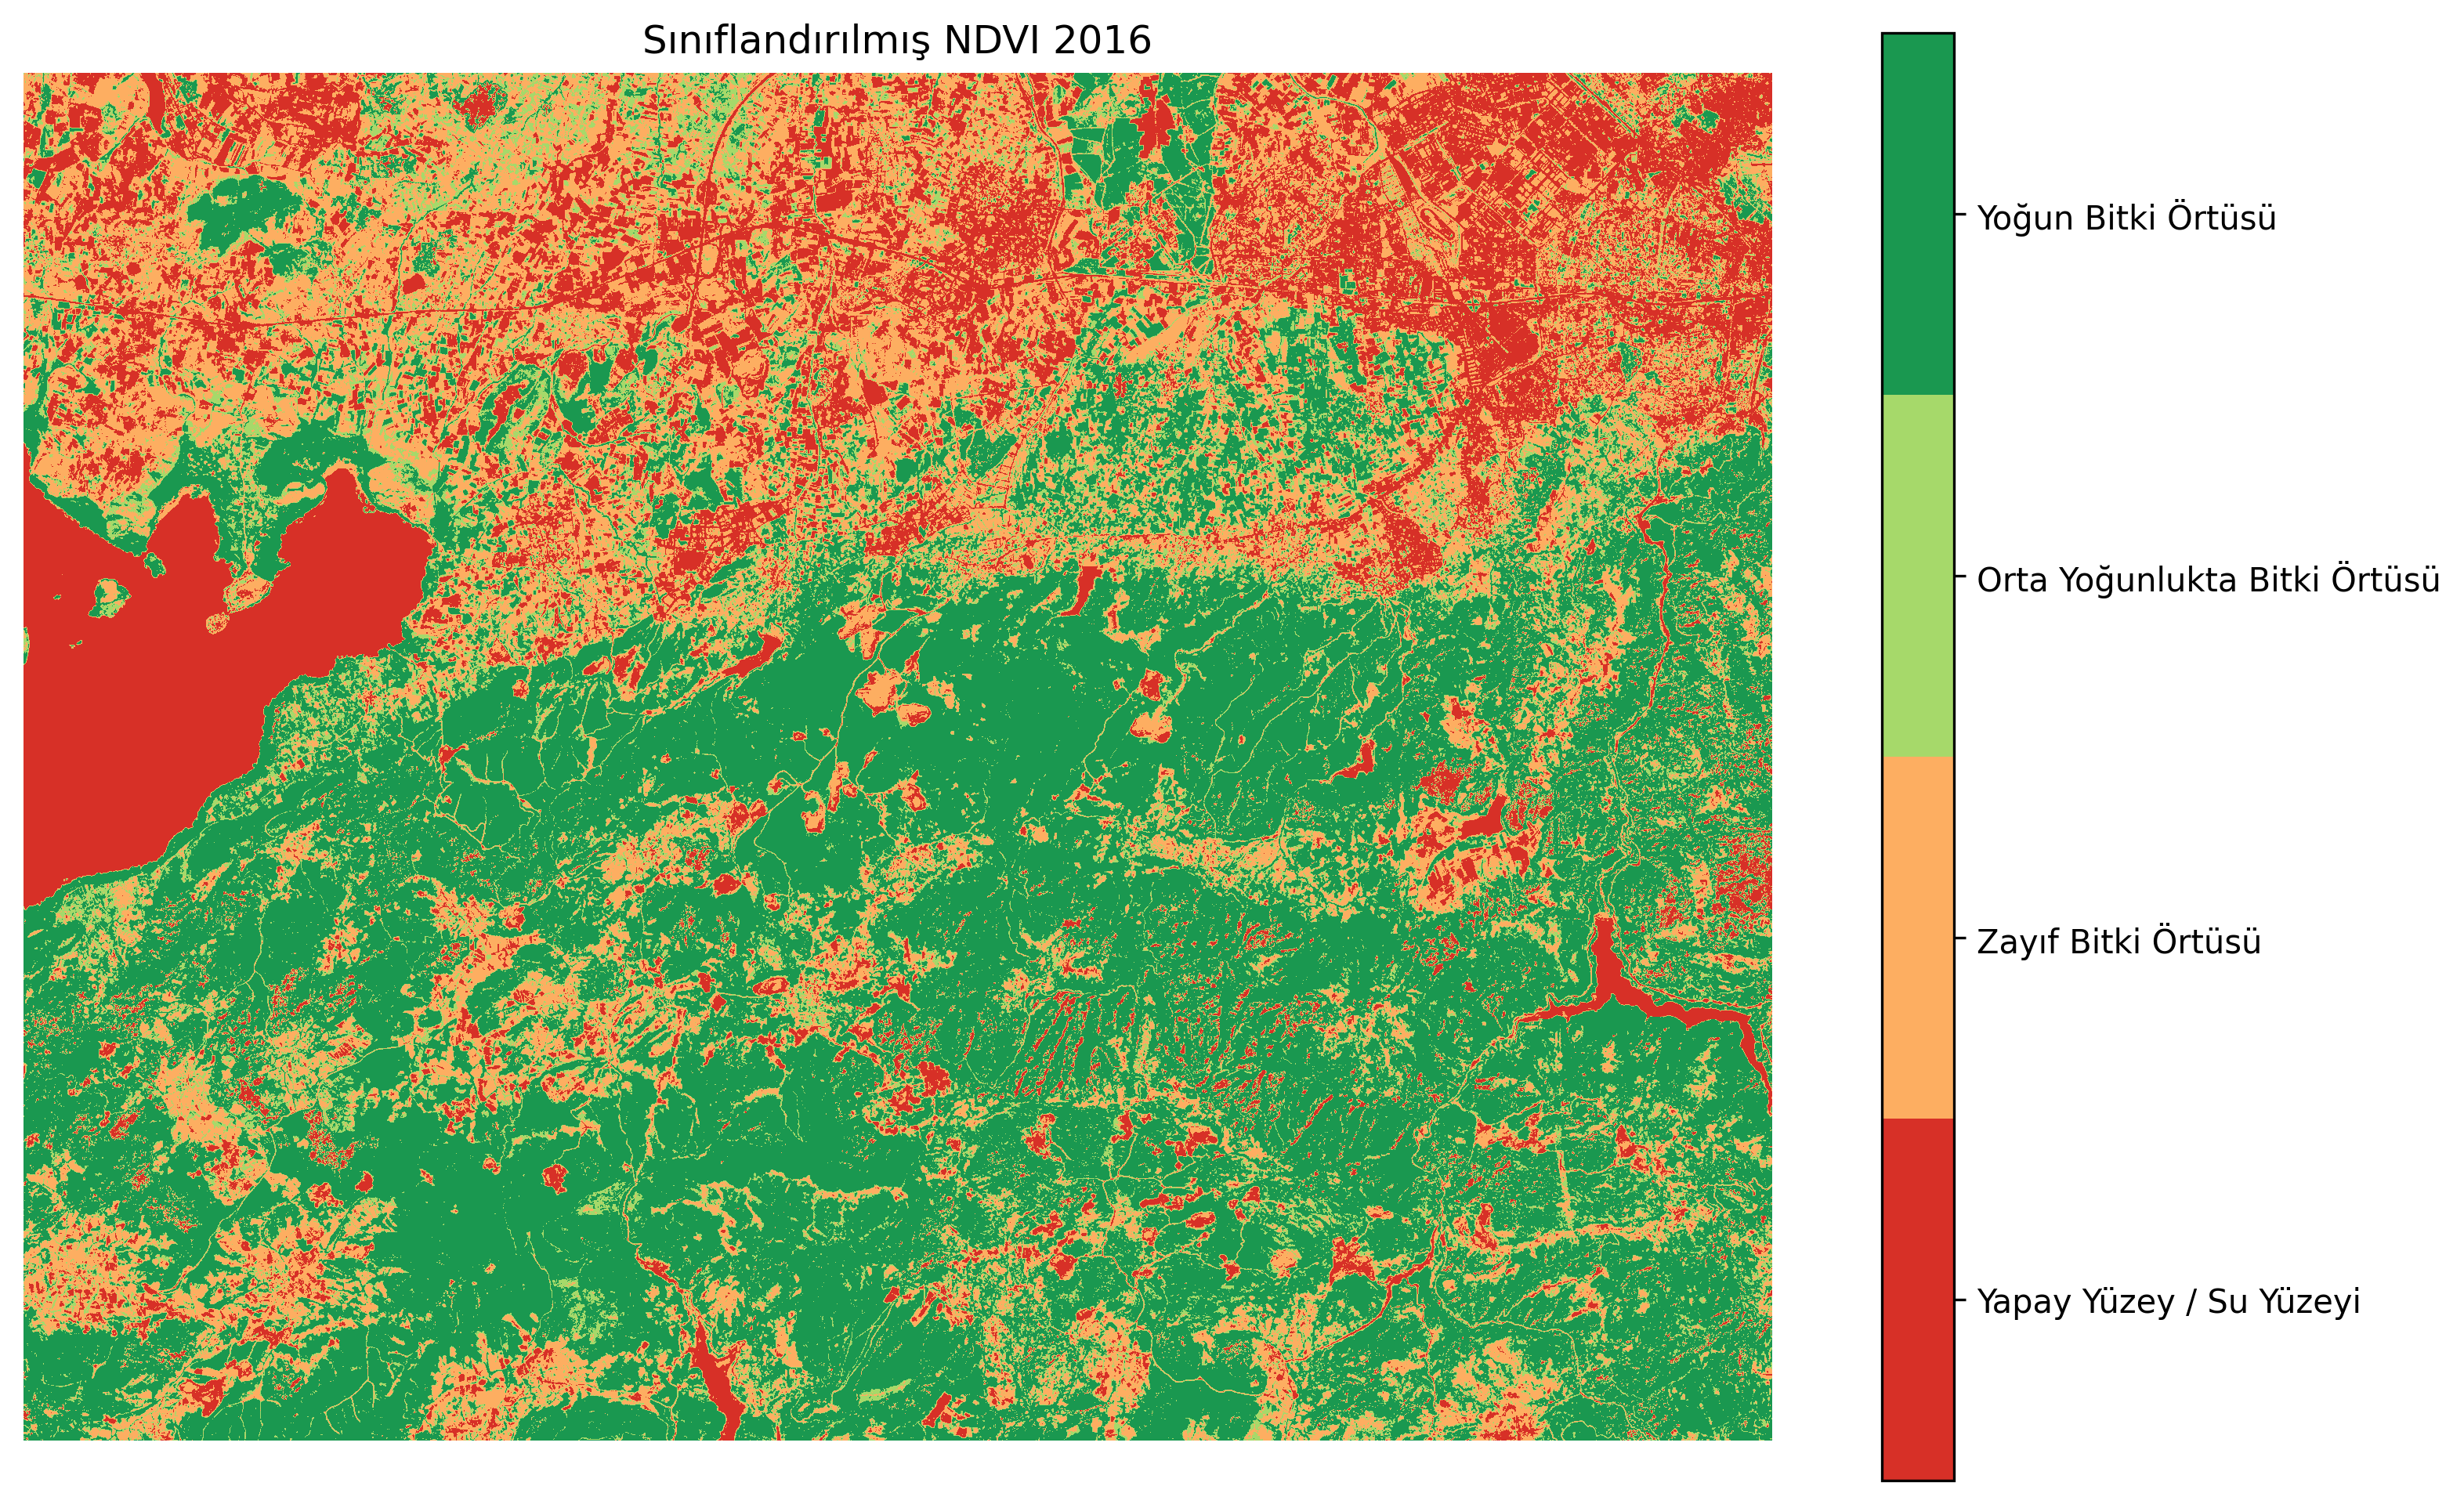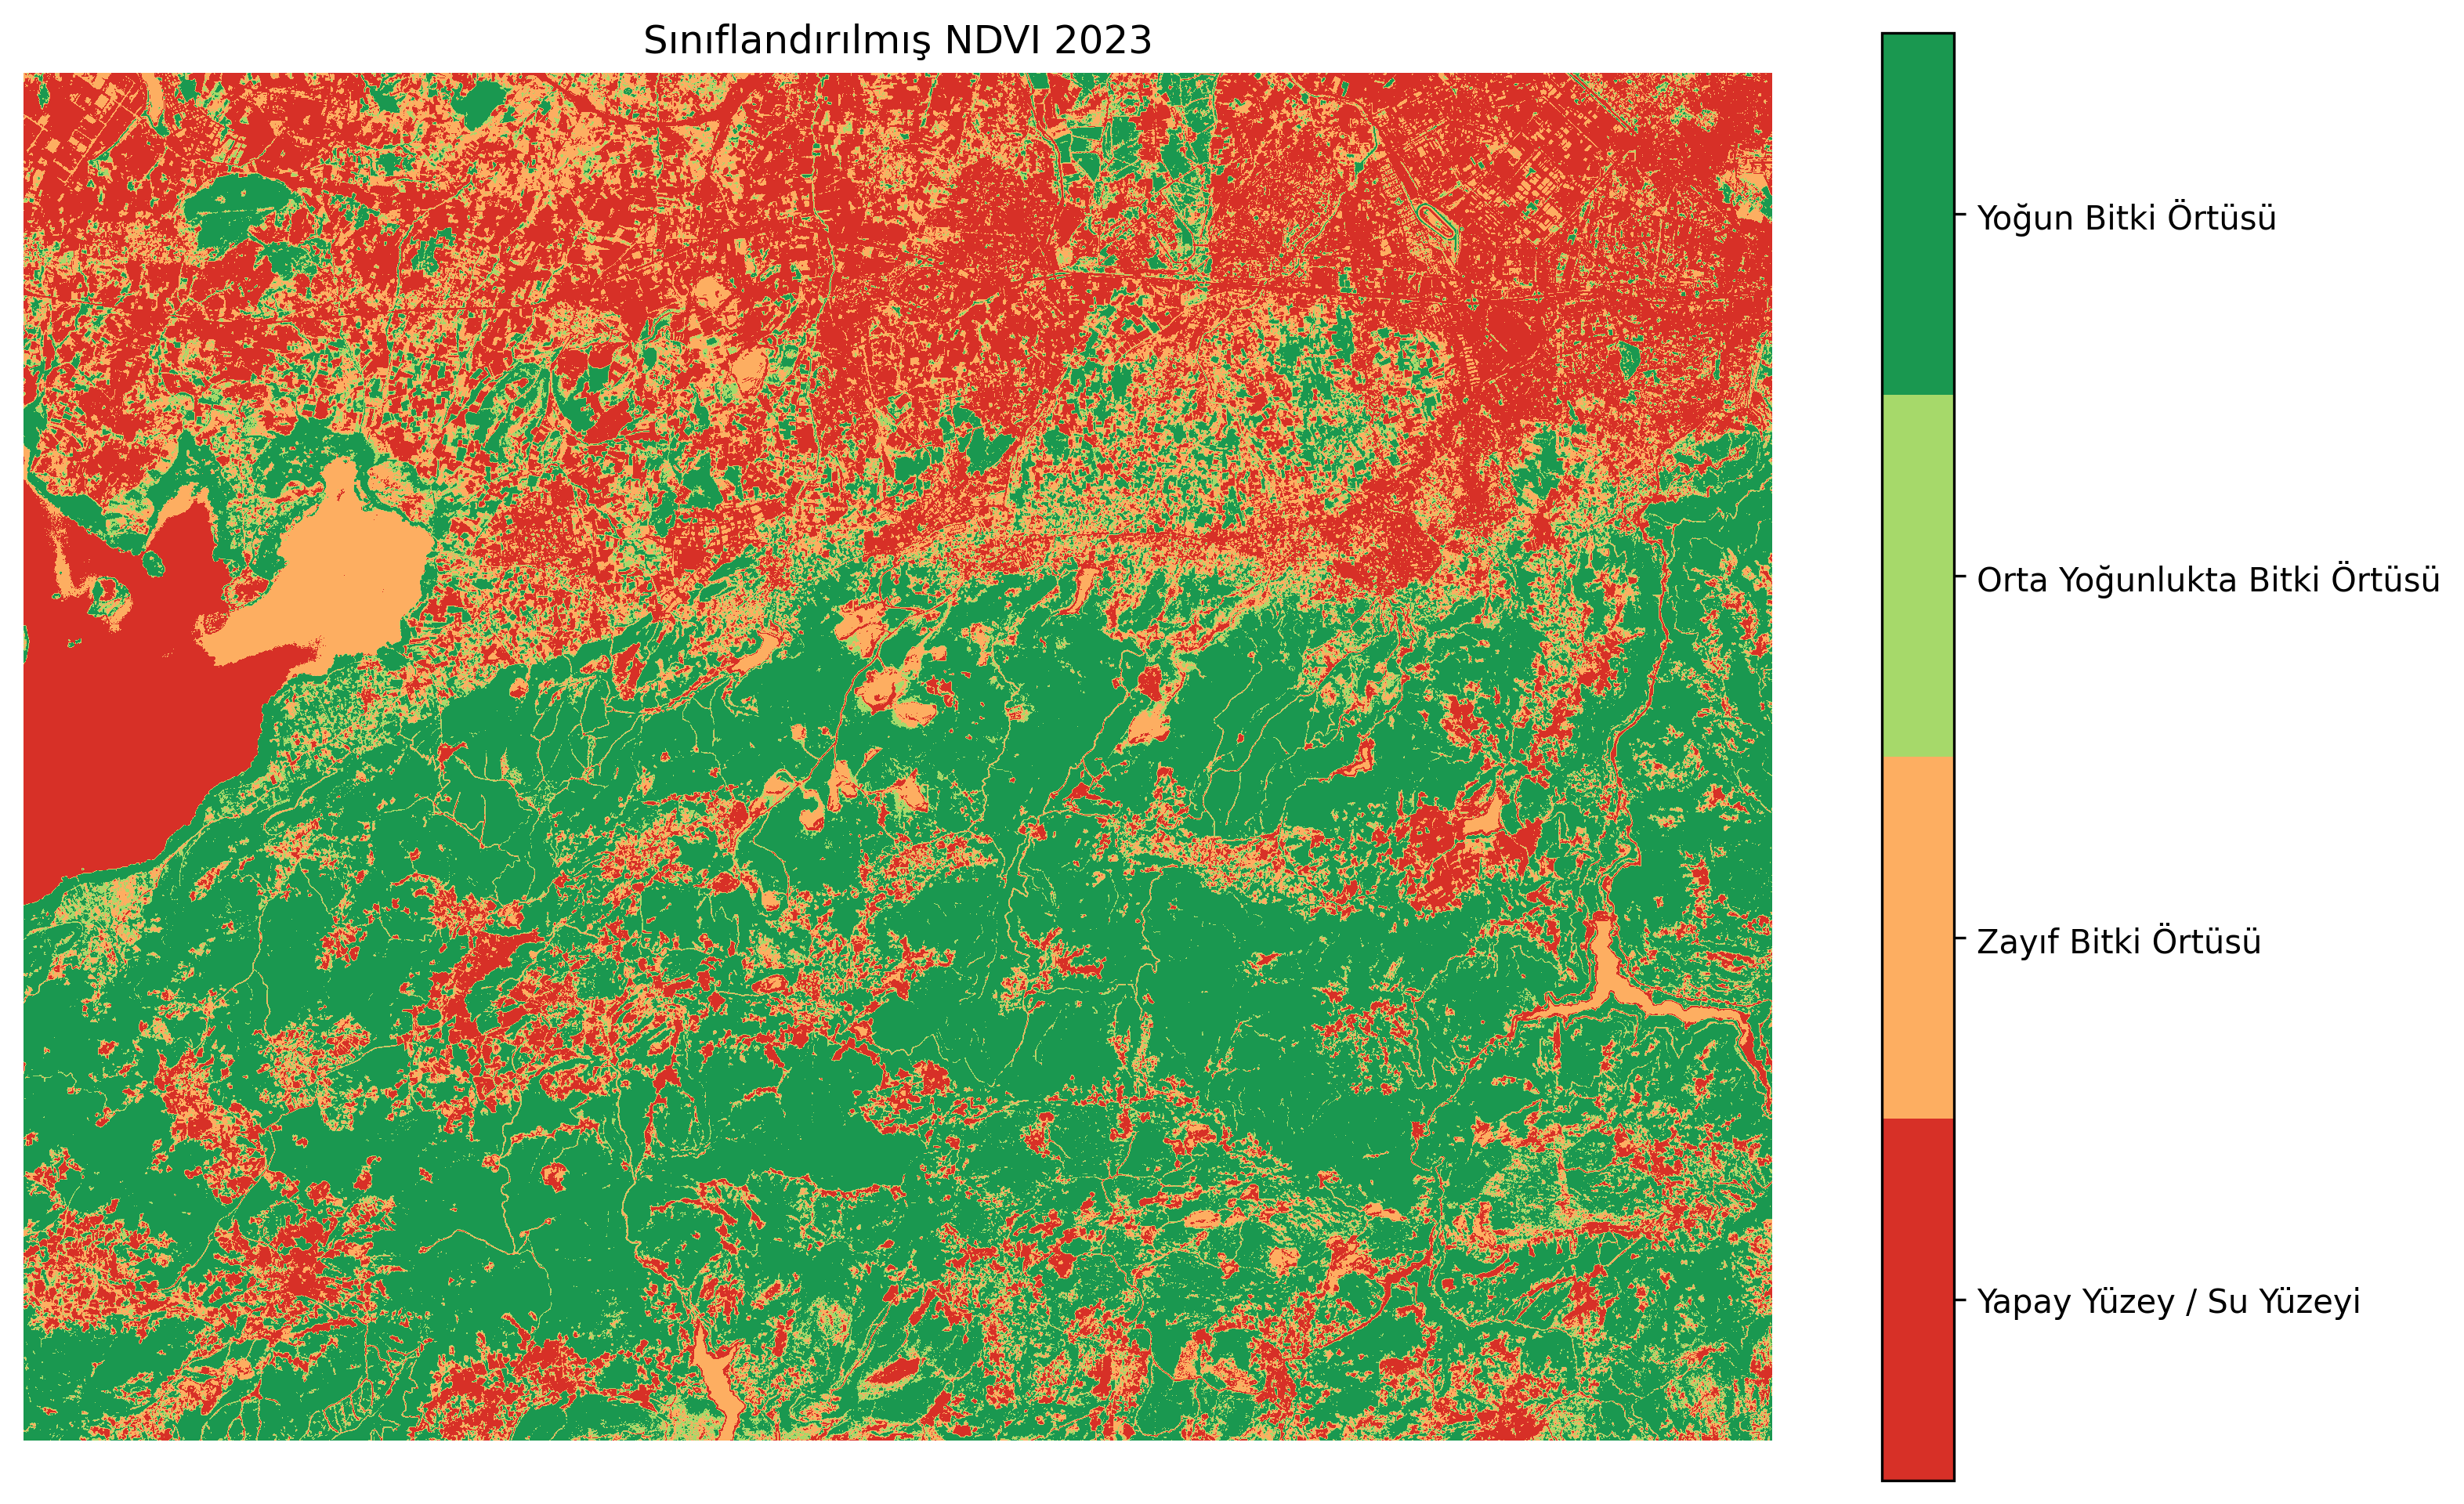

NDVI sınıflandırma haritaları, çalışma alanındaki arazi örtüsü değişimlerinin mekansal dağılımını göstermektedir. Haritalar dört temel sınıfı içermektedir: Yapay Yüzey / Su Yüzeyi, Zayıf Bitki Örtüsü, Orta Yoğunlukta Bitki Örtüsü ve Yoğun Bitki Örtüsü.

Mekansal bulgular,
*	Yapay yüzeylerdeki en belirgin artışın çalışma alanının kuzey kesiminde meydana geldiğini,
*	Yoğun bitki örtüsü kaybının özellikle kentsel gelişim alanlarının çeperlerinde yoğunlaştığını,
*	Zayıf bitki örtüsü sınıfındaki azalmanın, bu alanların yapay yüzeylere dönüşümünden kaynaklanmakta olduğunu,
*	Orta yoğunlukta bitki örtüsü sınıfının ise diğer sınıflara göre daha az değişim geçirmiş olduğunu göstermektedir.


NDVI sınıflarının yıllara göre değişimini gösteren karşılaştırmalı grafik, 2016-2023 döneminde yaşanan değişimleri net bir şekilde ortaya koymaktadır.
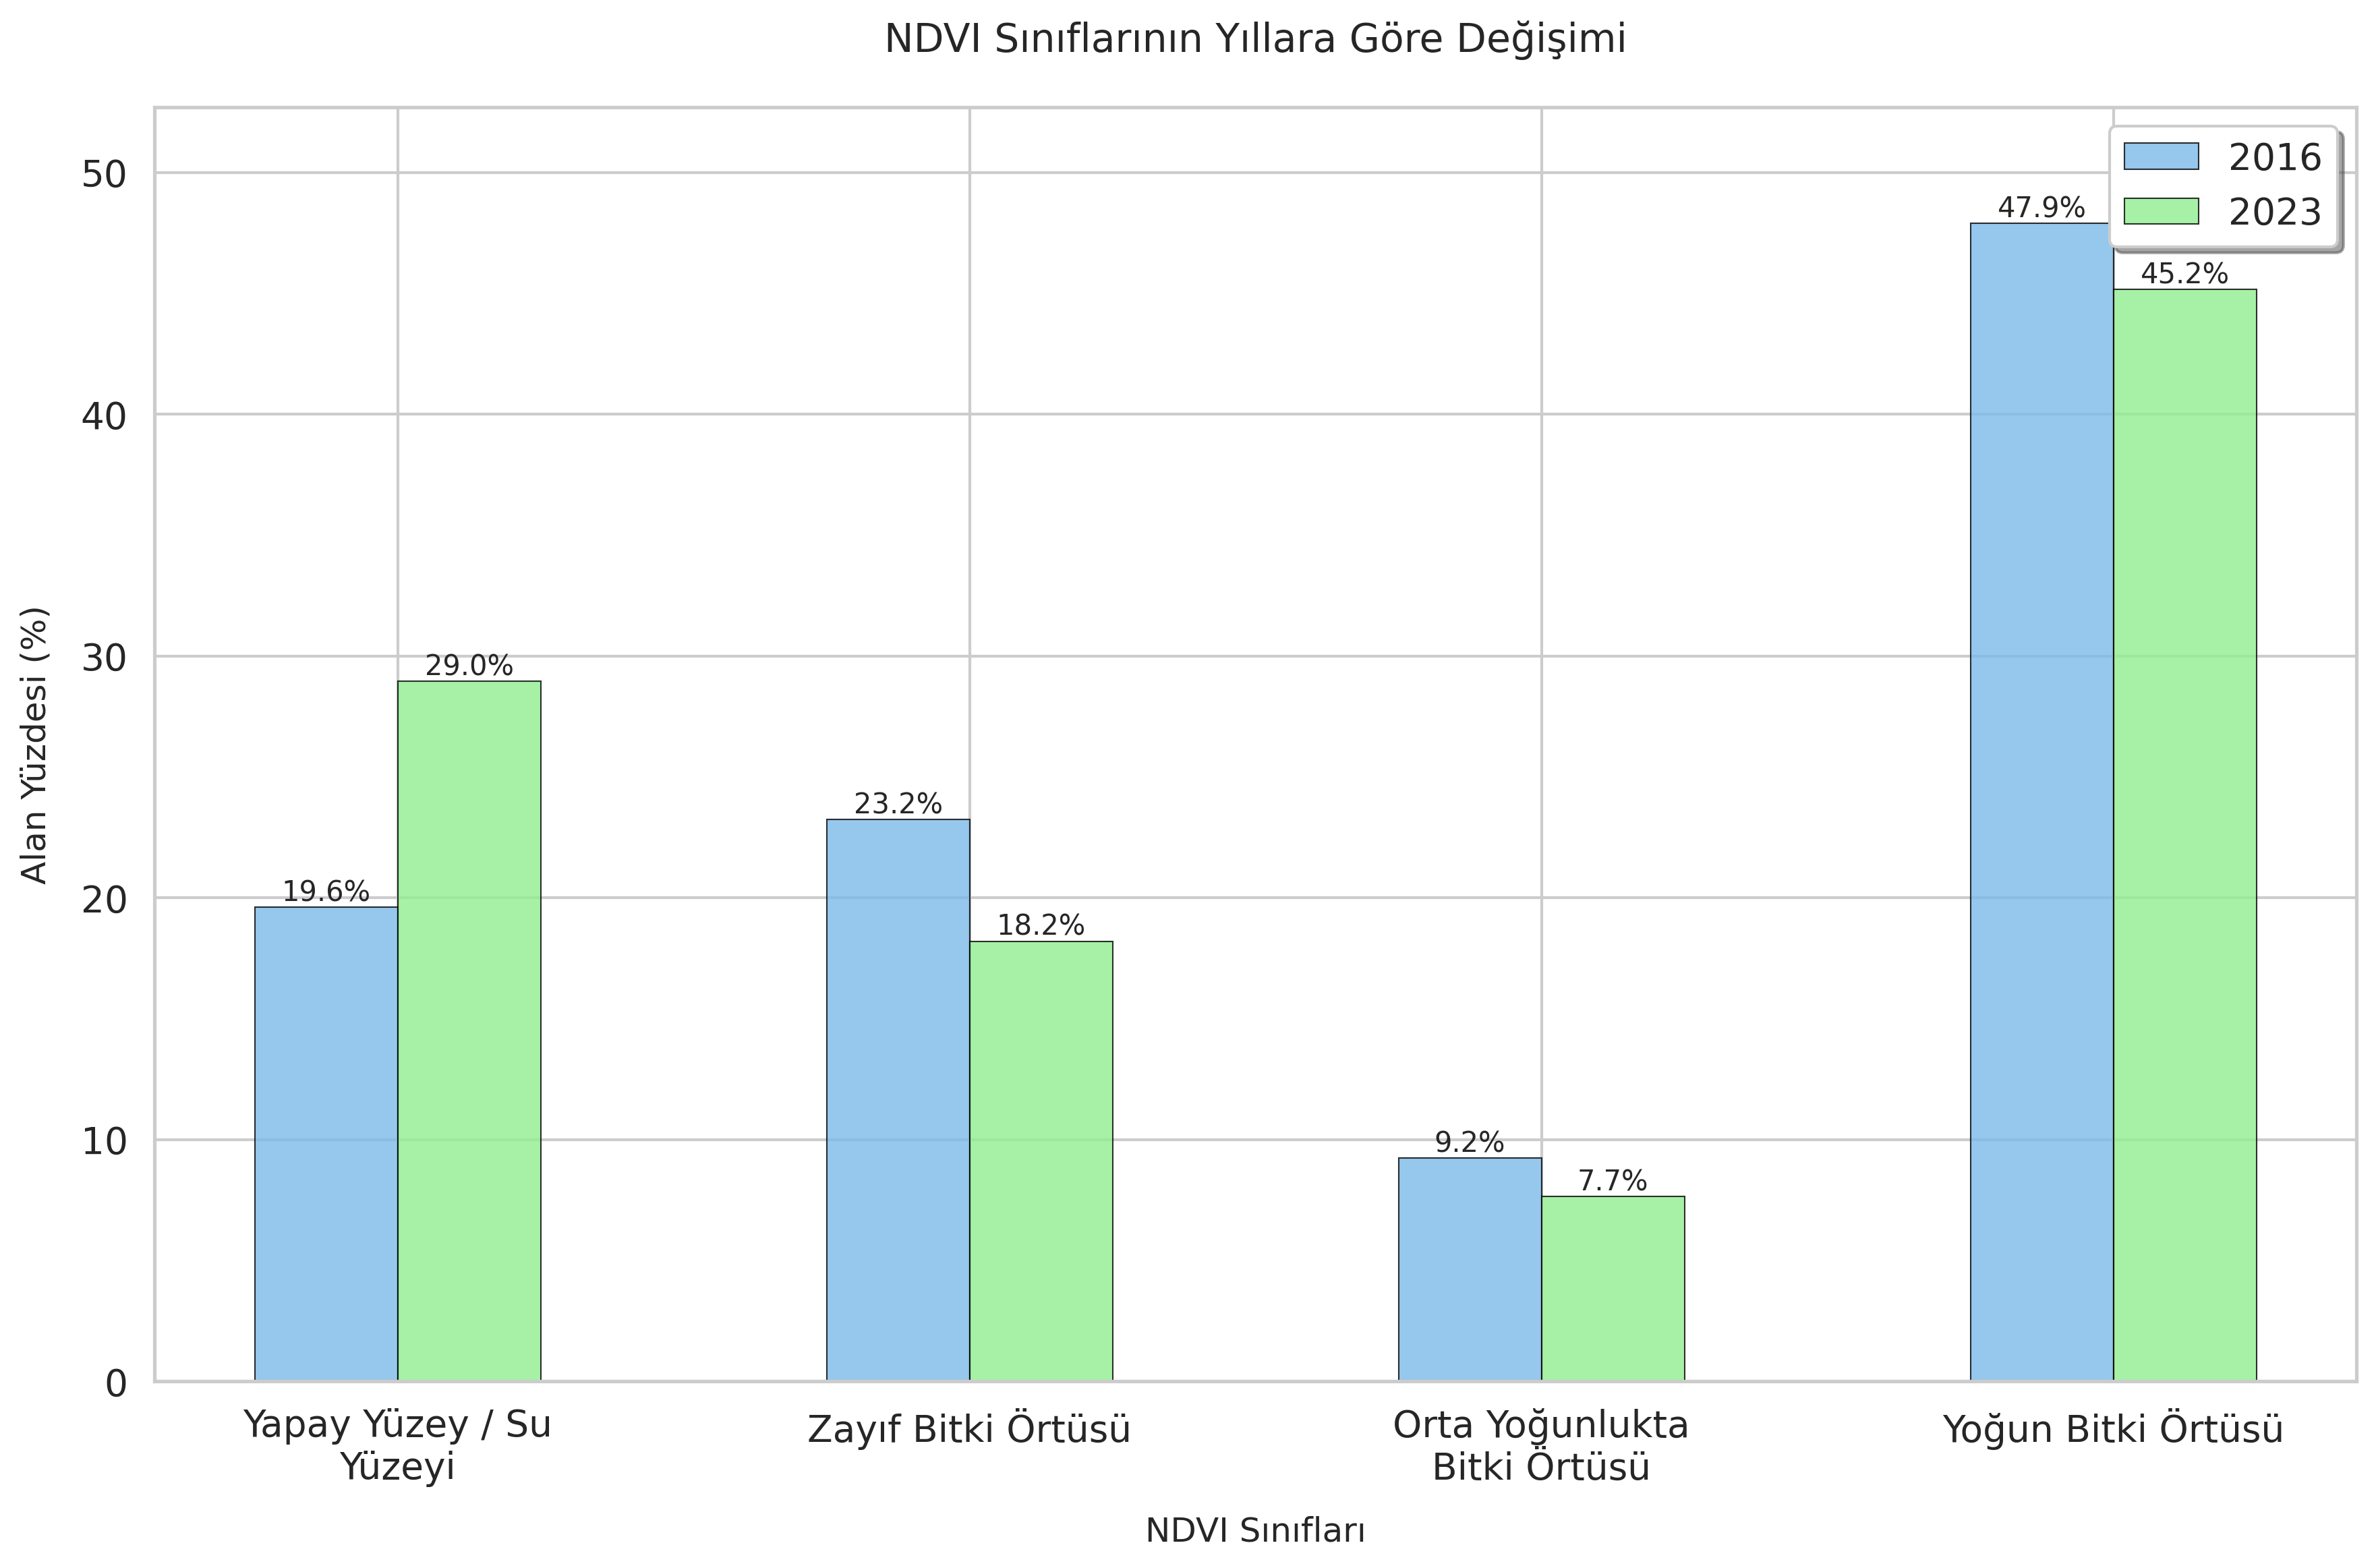

Grafiğe göre,

Yapay Yüzey/ Su Yüzeyi Sınıfı 2016'da yaklaşık %20 den 2023'te %29'a yükselerek grafikteki en belirgin yükseliş trendini göstermiştir. Yaklaşık %9'luk bu artış, diğer tüm sınıflardaki azalmaların toplamına karşılık gelmektedir.

Bitki Örtüsü Sınıflarında ise en yüksek orana sahip olan Yoğun Bitki Örtüsü sınıfı, %48'den %45'e düşüş göstermiştir. Zayıf Bitki Örtüsü Sınıfı %23'ten %18'e keskin bir düşüş yaşarken, Orta Yoğunlukta Bitki Örtüsü Sınıfı %9'dan %8'e minimal bir azalma göstererek en düşük değişim oranına sahip sınıf olmuştur.

Sonuç olarak,  tüm bitki örtüsü sınıflarında azalma trendi gözlenirken, sadece yapay yüzey sınıfında artış görülmüştür. En önemli değişim yapay yüzey artışı ve zayıf bitki örtüsü kaybında gözlenmiştir.

Bu bulgular, kentleşmenin bitki örtüsü üzerindeki baskısını açıkça ortaya koymaktadır. En belirgin NDVI değişimleri kent çeperlerinde ve gelişme aksları boyunca gözlenmiştir.


Metodolojik olarak değerlendirildiğinde ise, geleneksel haritacılık yöntemlerine kıyasla veri işleme süresi önemli ölçüde kısalmıştır. Batch processing özelliği sayesinde çoklu görüntü analizi eş zamanlı gerçekleştirilebildiğinden GIS yazılımlarına göre işlem süresi yaklaşık %70 azalmıştır. Yine sonuçların görselleştirilmesi ve raporlanması süreçleri entegre edildiğinden büyük oranda zamandan tasarruf edilmiştir. Ayrıca bantların ayrı ayrı işlenmesi ve normalize edilmesi, hesaplamaların doğruluğunu artırmıştır.